## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on amygdala (later hippocampus and vmPFC)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['vmpfc1','vmpfc2','vmpfc3'])
df_long

scr_id  groupIdx variable     value
0    KPE008         1   vmpfc1  0.229618
1   KPE1223         1   vmpfc1  0.418279
2   KPE1253         0   vmpfc1 -0.087617
3   KPE1263         0   vmpfc1 -0.381604
4   KPE1293         1   vmpfc1  0.175758
..      ...       ...      ...       ...
73  KPE1561         0   vmpfc3  0.190942
74  KPE1573         1   vmpfc3  1.362443
75  KPE1578         0   vmpfc3 -0.438874
76  KPE1587         1   vmpfc3       NaN
77  KPE1612         0   vmpfc3 -0.341237

[78 rows x 4 columns]

In [4]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value   
No. Observations:       73           Method:                  REML    
No. Groups:             26           Scale:                   0.2626  
Min. group size:        2            Log-Likelihood:          -58.8324
Max. group size:        3            Converged:               Yes     
Mean group size:        2.8                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   -0.032    0.144 -0.223 0.824 -0.315  0.251
variable[T.vmpfc2]           0.111    0.205  0.542 0.588 -0.291  0.514
variable[T.vmpfc3]           0.049    0.216  0.226 0.821 -0.375  0.472
groupIdx                    -0.006    0.204 -0.031 0.976 -0.407  0.394
variable[T.vmpfc2]:grou

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [5]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.029      1     19  0.029  0.091    0.766  0.005  nan
variable     0.052      2     38  0.026  0.093    0.911  0.005    0.928
Interaction  0.033      2     38  0.016  0.059    0.942  0.003  nan



## Build a Bayesian model
- Here we would model each subject under each group

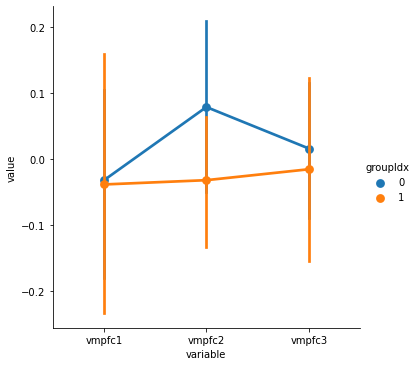

In [6]:
sns.catplot(y='value',x='variable', hue='groupIdx', kind = 'point', data=df_long, ci=68)

In [7]:
#df[['hippo1','hippo2','hippo3', 'hippo4','groupIdx']].groupby('groupIdx').describe()
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        vmpfc1    13.0 -0.032211  0.542302 -0.881910 -0.381604 -0.087617   
         vmpfc2    12.0  0.078617  0.460541 -0.914481 -0.046206  0.193359   
         vmpfc3    10.0  0.015832  0.341108 -0.438874 -0.269189 -0.011334   
1        vmpfc1    13.0 -0.038463  0.757460 -1.529759 -0.272918  0.083180   
         vmpfc2    13.0 -0.031971  0.389262 -0.718012 -0.203011 -0.033048   
         vmpfc3    12.0 -0.015453  0.483706 -0.374032 -0.314905 -0.191160   

                                       
                        75%       max  
groupIdx variable                      
0        vmpfc1    0.288639  0.879333  
         vmpfc2    0.330318  0.629830  
         vmpfc3    0.263908  0.624952  
1        vmpfc1    0.418279  1.284006  
         vmpfc2    0.111630  0.796530  
         vmpfc3    0.085462  1.362443

In [8]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['vmpfc1','vmpfc2','vmpfc3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [9]:
## Run similar model but without hyperpriors
# now we build a model - modeling the score of each group on each time point
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.1, shape=4)
    #inter = pm.Normal('inter', mu=0, sd=0.1, shape=4) # modeling interaction for each treatment
    
    bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=1) #
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + bMed*df_long.groupIdx 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(4000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, b, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 9 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'bMed'}>,
        <AxesSubplot:title={'center':'bMed'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

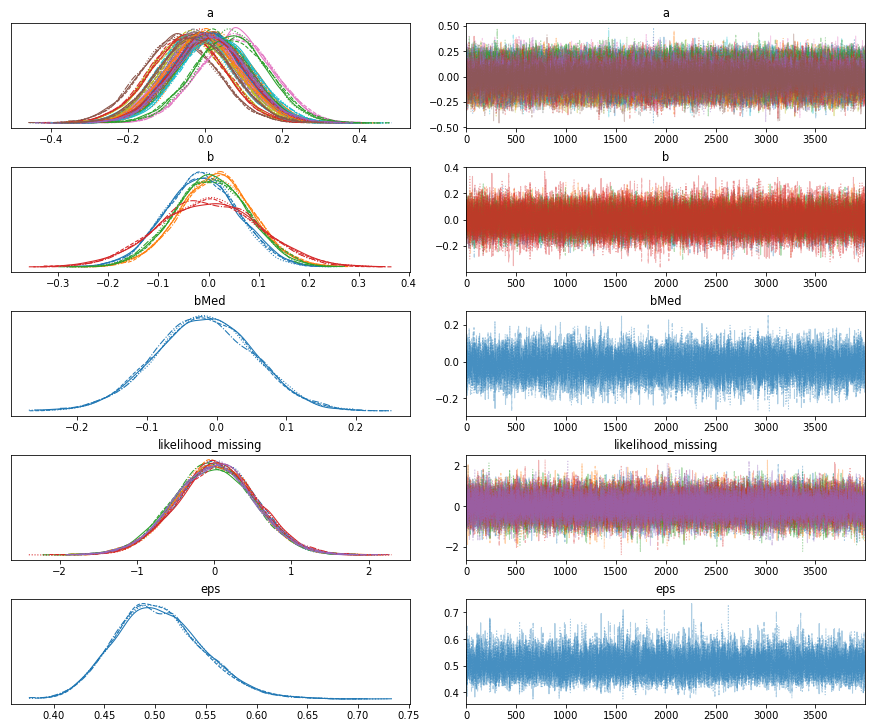

In [10]:
az.plot_trace(trace)

In [11]:
az.summary(trace, hdi_prob=.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
a[0]                   0.015  0.097  -0.144    0.172      0.001    0.001   
a[1]                   0.016  0.095  -0.140    0.171      0.001    0.001   
a[2]                   0.004  0.095  -0.157    0.157      0.001    0.001   
a[3]                  -0.006  0.097  -0.156    0.165      0.001    0.001   
a[4]                  -0.011  0.095  -0.166    0.148      0.001    0.001   
a[5]                  -0.069  0.097  -0.225    0.091      0.001    0.001   
a[6]                   0.079  0.095  -0.079    0.232      0.001    0.001   
a[7]                  -0.008  0.095  -0.166    0.144      0.001    0.001   
a[8]                  -0.045  0.095  -0.196    0.115      0.001    0.001   
a[9]                  -0.027  0.095  -0.178    0.135      0.001    0.001   
a[10]                  0.003  0.094  -0.149    0.156      0.001    0.001   
a[11]                  0.027  0.094  -0.124    0.184      0.001    0.001   
a[12]                  0.020  0.094  -0.137    0.173      0.001    0.001   
a[13]                 -0.047  0.096  -0.198    0.116      0.001    0.001   
a[14]                  0.002  0.094  -0.151    0.158      0.001    0.001   
a[15]                  0.015  0.095  -0.143    0.170      0.001    0.001   
a[16]                 -0.007  0.095  -0.162    0.151      0.001    0.001   
a[17]                 -0.025  0.094  -0.179    0.131      0.001    0.001   
a[18]                 -0.019  0.097  -0.180    0.136      0.001    0.001   
a[19]                  0.030  0.096  -0.121    0.192      0.001    0.001   
a[20]                  0.005  0.094  -0.154    0.158      0.001    0.001   
a[21]                 -0.006  0.095  -0.159    0.156      0.001    0.001   
a[22]                  0.065  0.096  -0.093    0.220      0.001    0.001   
a[23]                  0.007  0.096  -0.151    0.164      0.001    0.001   
a[24]                  0.013  0.096  -0.143    0.170      0.001    0.001   
a[25]                 -0.027  0.095  -0.183    0.131      0.001    0.001   
b[0]                  -0.014  0.073  -0.139    0.101      0.000    0.001   
b[1]                   0.015  0.074  -0.110    0.133      0.001    0.001   
b[2]                   0.005  0.075  -0.116    0.129      0.001    0.001   
b[3]                   0.000  0.100  -0.164    0.165      0.001    0.001   
bMed[0]               -0.017  0.071  -0.133    0.099      0.000    0.001   
likelihood_missing[0]  0.022  0.515  -0.831    0.850      0.003    0.004   
likelihood_missing[1]  0.010  0.517  -0.837    0.852      0.004    0.004   
likelihood_missing[2] -0.011  0.523  -0.822    0.888      0.004    0.004   
likelihood_missing[3]  0.043  0.522  -0.827    0.884      0.003    0.004   
likelihood_missing[4]  0.001  0.525  -0.868    0.856      0.004    0.004   
eps                    0.504  0.044   0.432    0.572      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
a[0]                    25994.0   13130.0    1.0  
a[1]                    27830.0   11673.0    1.0  
a[2]                    24259.0   12583.0    1.0  
a[3]                    22343.0   11965.0    1.0  
a[4]                    27530.0   12147.0    1.0  
a[5]                    23178.0   12461.0    1.0  
a[6]                    22519.0   12670.0    1.0  
a[7]                    25050.0   13039.0    1.0  
a[8]                    22010.0   13085.0    1.0  
a[9]                    25798.0   12377.0    1.0  
a[10]                   23752.0   12742.0    1.0  
a[11]                   24867.0   12804.0    1.0  
a[12]                   25384.0   12689.0    1.0  
a[13]                   24606.0   12411.0    1.0  
a[14]                   22406.0   11059.0    1.0  
a[15]                   23604.0   12586.0    1.0  
a[16]                   29703.0   12364.0    1.0  
a[17]                   25736.0   12312.0    1.0  
a[18]                   21926.0   12755.0    1.0  
a[19]                   23720.0   12163.0    1.0  
a[20]                   29289.0   12521.0    1.0  
a[21]        

0.4571875

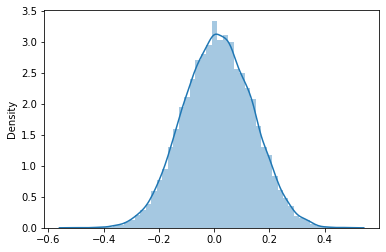

In [12]:
diffTime = trace.posterior['b'].data[:,:,3] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
sum(diffTime.ravel()<0)/len(diffTime.ravel())

In [13]:
# assess difference HDI
print(f'Mean {np.mean(diffTime.ravel())}')
print(f'SD {np.std(diffTime.ravel())}')
pm.stats.hdi(diffTime.ravel(), hdi_prob=.9)

Mean 0.014028854176507505
SD 0.12454774137645337


array([-0.18679187,  0.22033365])

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [14]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.032  0.208  -0.357    0.320      0.005    0.005    1571.0   
groupIdx  -0.002  0.296  -0.478    0.469      0.007    0.006    1675.0   
sd         0.702  0.110   0.528    0.868      0.002    0.002    2098.0   

           ess_tail  r_hat  
Intercept    1528.0    1.0  
groupIdx     1756.0    1.0  
sd           1956.0    1.0

In [15]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.086  0.132  -0.134    0.296      0.003    0.002    1742.0   
groupIdx  -0.120  0.181  -0.408    0.182      0.004    0.003    1684.0   
sd         0.448  0.070   0.338    0.551      0.002    0.001    1887.0   

           ess_tail  r_hat  
Intercept    1922.0    1.0  
groupIdx     1955.0    1.0  
sd           1719.0    1.0

In [16]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.020  0.152  -0.236    0.262      0.004    0.003    1656.0   
groupIdx  -0.040  0.206  -0.351    0.322      0.005    0.004    1632.0   
sd         0.455  0.081   0.332    0.583      0.002    0.001    1629.0   

           ess_tail  r_hat  
Intercept    1790.0    1.0  
groupIdx     1813.0    1.0  
sd           1251.0    1.0

In [19]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=2000, tune=2000,target_accept=0.9, return_inferencedata=False, cores=4)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [18]:
ses1trace, ses1Diff = runModel('vmpfc1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, bMed, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


Group difference is 0.5021875


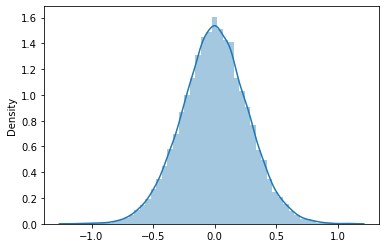

In [20]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


Group difference is 0.256875


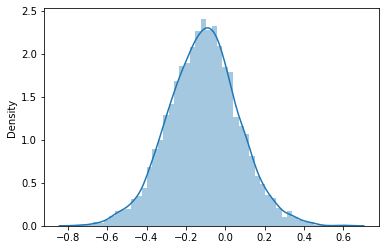

In [21]:
ses2trace, ses2Diff = runModel('vmpfc2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


Group difference is 0.423


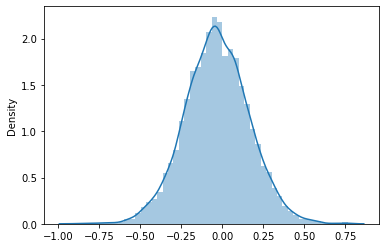

In [22]:
ses3trace, ses3Diff = runModel('vmpfc3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')